Import libraries

In [1]:
import pandas as pd
from prophet import Prophet
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

import sys
from pathlib import Path

parent_dir = Path.cwd().parent.parent

if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
from shared.metrics import print_evaluation_metrics
from shared.helpers import store_model

/home/samuell/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Load dataset and prepare df

In [2]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date"
target_column = "Close"
df = pd.read_csv(file_path, parse_dates=True)
df = df[[date_column, target_column]]

df.set_index(date_column, inplace=True)
df = df.groupby(date_column).sum().reset_index()

df = df.dropna()
df.rename(columns={date_column: 'ds', target_column: 'y'}, inplace=True)
df['floor'] = 0
dates = df['ds'].values

Train test split

In [3]:
data_length = len(df)
train_split = 0.9
train = df.iloc[:int(data_length*train_split)]
test = df.iloc[int(data_length*train_split):]

Tune Model

In [4]:
# Set up parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative']
}# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]# Create a list to store MAPE values for each combination
mapes = [] # Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params, changepoint_range=0.9).fit(train)  
    # Cross-validation
    df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    mapes.append(df_p['mape'].values[0])
    
# Tuning results
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes# Find the best parameters
best_params = all_params[np.argmin(mapes)]
print(best_params)

14:15:06 - cmdstanpy - INFO - Chain [1] start processing
14:15:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:15:08 - cmdstanpy - INFO - Chain [1] start processing
14:15:08 - cmdstanpy - INFO - Chain [1] start processing
14:15:08 - cmdstanpy - INFO - Chain [1] done processing
14:15:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:15:08 - cmdstanpy - INFO - Chain [1] done processing
14:15:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:15:08 - cmdstanpy - INFO - Chain [1] start processing
14:15:08 - cmdstanpy - INFO - Chain [1] start processing
14:15:08 - cmdstanpy - INFO - Chain [1] start processing
14:15:08 - cmdstanpy - INFO - Chain [1] done processing
14:15:08 - cmdstan

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'seasonality_mode': 'additive'}


In [5]:
auto_model = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                     seasonality_prior_scale=best_params['seasonality_prior_scale'], 
                     seasonality_mode=best_params['seasonality_mode'], changepoint_range=0.9)
auto_model.fit(train)

14:37:53 - cmdstanpy - INFO - Chain [1] start processing
14:37:56 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:37:57 - cmdstanpy - INFO - Chain [1] start processing
14:37:57 - cmdstanpy - INFO - Chain [1] start processing
14:37:57 - cmdstanpy - INFO - Chain [1] start processing
14:37:57 - cmdstanpy - INFO - Chain [1] start processing
14:37:57 - cmdstanpy - INFO - Chain [1] start processing
14:37:57 - cmdstanpy - INFO - Chain [1] start processing
14:37:57 - cmdstanpy - INFO - Chain [1] start processing
14:37:57 - cmdstanpy - INFO - Chain [1] start processing
14:37:57 - cmdstanpy - INFO - Chain [1] start processing
14:37:57 - cmdstanpy - INFO - Chain [1] start processing
14:37:57 - cmdstanpy - INFO - Chain [1] start processing
14:37:57 - cmdstanpy - INFO - Chain [1] start processing
14:37:57 - cmdstanpy - INFO - Chain [1] start processing
14:37:57 - cmdstanpy - INFO - Chain [1] st

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,2.933675e+07,5416.340834,2995.206161,0.188136,0.129829,0.186509,0.336704


In [5]:
pred = auto_model.predict(test[['ds']])

In [6]:
non_zero = []
import sys
 
for i in pred['yhat']:
    if i == 0:
        non_zero.append(i+sys.float_info.min)
    else:
        non_zero.append(i)
print_evaluation_metrics(non_zero, test['y'], train['y'])

Evaluation Metrics:
MSE: 746460001.08
RMSE: 27321.42
MAE: 24885.74
MAPE: 76.19
SMAPE: 134.22
MASE: 69.08


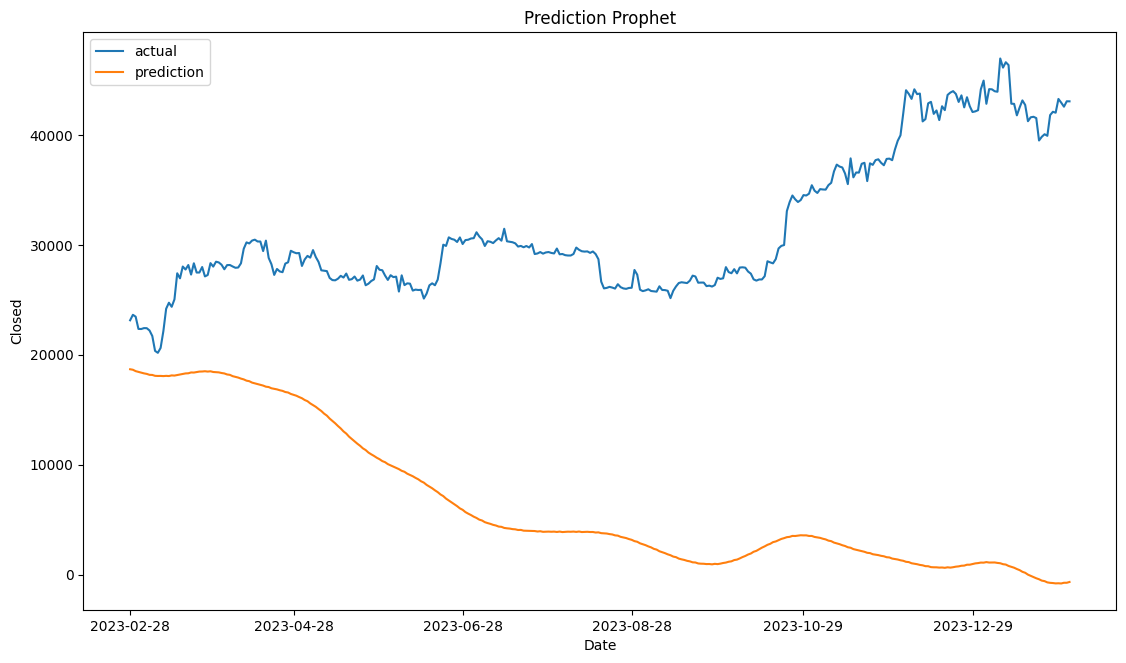

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(test['ds'], test['y'].values, label="actual")
ax.plot(test['ds'], pred['yhat'], label="prediction")
ax.set_title("Prediction Prophet")
ax.set_ylabel("Closed")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [8]:
store_model(auto_model, "prophet")

In [9]:
# Create a copy of the data
data_log = df.copy()# Create the log scale data by taking the natual log of the stock prices.
data_log['y_log'] = np.log(df['y'])
data_log = data_log.drop('y', axis=1).rename(columns={'y_log': 'y'})
data_log.head()

,ds,floor,y
0,2014-10-17,0,5.950012
1,2014-10-18,0,5.969837
2,2014-10-19,0,5.964982
3,2014-10-20,0,5.947630
4,2014-10-21,0,5.957067


In [10]:
# Parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1.0, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative']
}# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Store the MAPEs for each params here# Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params).fit(data_log)
    # Cross-validation
    df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    print(df_p)
    mapes.append(df_p['smape'].values[0])# Tuning results
best_params = all_params[np.argmin(mapes)]# Best parameters
print(best_params)# Train model using best parameters
auto_model_log = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                     seasonality_prior_scale=best_params['seasonality_prior_scale'], 
                     seasonality_mode=best_params['seasonality_mode'])# Fit the model on the training dataset
auto_model_log.fit(data_log)# Cross validation
auto_model_log_cv = cross_validation(auto_model_log, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")# Model performance metrics
auto_model_log_p = performance_metrics(auto_model_log_cv, rolling_window=1)
auto_model_log_p

14:38:41 - cmdstanpy - INFO - Chain [1] start processing
14:38:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:38:43 - cmdstanpy - INFO - Chain [1] start processing
14:38:43 - cmdstanpy - INFO - Chain [1] start processing
14:38:43 - cmdstanpy - INFO - Chain [1] start processing
14:38:43 - cmdstanpy - INFO - Chain [1] start processing
14:38:43 - cmdstanpy - INFO - Chain [1] start processing
14:38:43 - cmdstanpy - INFO - Chain [1] start processing
14:38:43 - cmdstanpy - INFO - Chain [1] done processing
14:38:43 - cmdstanpy - INFO - Chain [1] start processing
14:38:43 - cmdstanpy - INFO - Chain [1] start processing
14:38:43 - cmdstanpy - INFO - Chain [1] done processing
14:38:43 - cmdstanpy - INFO - Chain [1] start processing
14:38:43 - cmdstanpy - INFO - Chain [1] done processing
14:38:43 - cmdstanpy - INFO - Chain [1] done processing
14:38:43 - cmdstanpy - INFO - Chain [1] done p

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.412038  0.641902  0.513204  0.057088  0.046478  0.055768   

   coverage  
0  0.459736  


14:38:56 - cmdstanpy - INFO - Chain [1] start processing
14:38:56 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:38:57 - cmdstanpy - INFO - Chain [1] start processing
14:38:57 - cmdstanpy - INFO - Chain [1] start processing
14:38:57 - cmdstanpy - INFO - Chain [1] start processing
14:38:57 - cmdstanpy - INFO - Chain [1] start processing
14:38:57 - cmdstanpy - INFO - Chain [1] start processing
14:38:57 - cmdstanpy - INFO - Chain [1] start processing
14:38:57 - cmdstanpy - INFO - Chain [1] start processing
14:38:57 - cmdstanpy - INFO - Chain [1] start processing
14:38:57 - cmdstanpy - INFO - Chain [1] start processing
14:38:57 - cmdstanpy - INFO - Chain [1] done processing
14:38:57 - cmdstanpy - INFO - Chain [1] start processing
14:38:57 - cmdstanpy - INFO - Chain [1] start processing
14:38:57 - cmdstanpy - INFO - Chain [1] done processing
14:38:57 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.463011  0.680449  0.546142  0.060743  0.049555  0.059238   

   coverage  
0  0.460726  


14:39:09 - cmdstanpy - INFO - Chain [1] start processing
14:39:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:39:11 - cmdstanpy - INFO - Chain [1] start processing
14:39:11 - cmdstanpy - INFO - Chain [1] done processing
14:39:11 - cmdstanpy - INFO - Chain [1] start processing
14:39:11 - cmdstanpy - INFO - Chain [1] start processing
14:39:11 - cmdstanpy - INFO - Chain [1] start processing
14:39:11 - cmdstanpy - INFO - Chain [1] done processing
14:39:11 - cmdstanpy - INFO - Chain [1] start processing
14:39:11 - cmdstanpy - INFO - Chain [1] start processing
14:39:11 - cmdstanpy - INFO - Chain [1] start processing
14:39:11 - cmdstanpy - INFO - Chain [1] start processing
14:39:11 - cmdstanpy - INFO - Chain [1] done processing
14:39:11 - cmdstanpy - INFO - Chain [1] done processing
14:39:11 - cmdstanpy - INFO - Chain [1] done processing
14:39:11 - cmdstanpy - INFO - Chain [1] done pr

  horizon       mse     rmse       mae      mape     mdape     smape  coverage
0 30 days  0.410932  0.64104  0.511369  0.056918  0.045928  0.055564  0.457426


14:39:24 - cmdstanpy - INFO - Chain [1] start processing
14:39:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:39:26 - cmdstanpy - INFO - Chain [1] start processing
14:39:26 - cmdstanpy - INFO - Chain [1] start processing
14:39:26 - cmdstanpy - INFO - Chain [1] start processing
14:39:26 - cmdstanpy - INFO - Chain [1] start processing
14:39:26 - cmdstanpy - INFO - Chain [1] start processing
14:39:26 - cmdstanpy - INFO - Chain [1] start processing
14:39:26 - cmdstanpy - INFO - Chain [1] start processing
14:39:26 - cmdstanpy - INFO - Chain [1] start processing
14:39:26 - cmdstanpy - INFO - Chain [1] done processing
14:39:26 - cmdstanpy - INFO - Chain [1] start processing
14:39:26 - cmdstanpy - INFO - Chain [1] done processing
14:39:26 - cmdstanpy - INFO - Chain [1] start processing
14:39:26 - cmdstanpy - INFO - Chain [1] start processing
14:39:26 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.460568  0.678652  0.543445  0.060498  0.049824  0.058972   

   coverage  
0  0.457426  


14:39:37 - cmdstanpy - INFO - Chain [1] start processing
14:39:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:39:38 - cmdstanpy - INFO - Chain [1] start processing
14:39:38 - cmdstanpy - INFO - Chain [1] start processing
14:39:38 - cmdstanpy - INFO - Chain [1] start processing
14:39:38 - cmdstanpy - INFO - Chain [1] done processing
14:39:38 - cmdstanpy - INFO - Chain [1] start processing
14:39:38 - cmdstanpy - INFO - Chain [1] start processing
14:39:38 - cmdstanpy - INFO - Chain [1] done processing
14:39:38 - cmdstanpy - INFO - Chain [1] start processing
14:39:38 - cmdstanpy - INFO - Chain [1] start processing
14:39:39 - cmdstanpy - INFO - Chain [1] start processing
14:39:39 - cmdstanpy - INFO - Chain [1] done processing
14:39:39 - cmdstanpy - INFO - Chain [1] start processing
14:39:39 - cmdstanpy - INFO - Chain [1] start processing
14:39:39 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.414293  0.643656  0.514624  0.057329  0.046776  0.056001   

   coverage  
0  0.455116  


14:39:51 - cmdstanpy - INFO - Chain [1] start processing
14:39:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:39:53 - cmdstanpy - INFO - Chain [1] start processing
14:39:53 - cmdstanpy - INFO - Chain [1] start processing
14:39:53 - cmdstanpy - INFO - Chain [1] start processing
14:39:53 - cmdstanpy - INFO - Chain [1] done processing
14:39:53 - cmdstanpy - INFO - Chain [1] done processing
14:39:53 - cmdstanpy - INFO - Chain [1] start processing
14:39:53 - cmdstanpy - INFO - Chain [1] done processing
14:39:53 - cmdstanpy - INFO - Chain [1] start processing
14:39:53 - cmdstanpy - INFO - Chain [1] start processing
14:39:53 - cmdstanpy - INFO - Chain [1] start processing
14:39:53 - cmdstanpy - INFO - Chain [1] start processing
14:39:53 - cmdstanpy - INFO - Chain [1] start processing
14:39:53 - cmdstanpy - INFO - Chain [1] start processing
14:39:53 - cmdstanpy - INFO - Chain [1] done 

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.457115  0.676103  0.541528  0.060212  0.050054  0.058706   

   coverage  
0  0.459076  


14:40:08 - cmdstanpy - INFO - Chain [1] start processing
14:40:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:40:10 - cmdstanpy - INFO - Chain [1] start processing
14:40:10 - cmdstanpy - INFO - Chain [1] start processing
14:40:10 - cmdstanpy - INFO - Chain [1] start processing
14:40:10 - cmdstanpy - INFO - Chain [1] start processing
14:40:10 - cmdstanpy - INFO - Chain [1] start processing
14:40:10 - cmdstanpy - INFO - Chain [1] start processing
14:40:10 - cmdstanpy - INFO - Chain [1] done processing
14:40:10 - cmdstanpy - INFO - Chain [1] start processing
14:40:10 - cmdstanpy - INFO - Chain [1] done processing
14:40:10 - cmdstanpy - INFO - Chain [1] done processing
14:40:10 - cmdstanpy - INFO - Chain [1] done processing
14:40:10 - cmdstanpy - INFO - Chain [1] start processing
14:40:10 - cmdstanpy - INFO - Chain [1] start processing
14:40:10 - cmdstanpy - INFO - Chain [1] start 

  horizon       mse      rmse       mae      mape     mdape    smape  coverage
0 30 days  0.412822  0.642513  0.513053  0.057171  0.046558  0.05584  0.456106


14:40:24 - cmdstanpy - INFO - Chain [1] start processing
14:40:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:40:26 - cmdstanpy - INFO - Chain [1] start processing
14:40:26 - cmdstanpy - INFO - Chain [1] done processing
14:40:26 - cmdstanpy - INFO - Chain [1] start processing
14:40:26 - cmdstanpy - INFO - Chain [1] start processing
14:40:26 - cmdstanpy - INFO - Chain [1] start processing
14:40:26 - cmdstanpy - INFO - Chain [1] start processing
14:40:26 - cmdstanpy - INFO - Chain [1] start processing
14:40:26 - cmdstanpy - INFO - Chain [1] done processing
14:40:26 - cmdstanpy - INFO - Chain [1] start processing
14:40:26 - cmdstanpy - INFO - Chain [1] start processing
14:40:26 - cmdstanpy - INFO - Chain [1] start processing
14:40:26 - cmdstanpy - INFO - Chain [1] start processing
14:40:26 - cmdstanpy - INFO - Chain [1] done processing
14:40:26 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.456232  0.675449  0.541669  0.060256  0.049647  0.058744   

   coverage  
0  0.458746  


14:40:39 - cmdstanpy - INFO - Chain [1] start processing
14:40:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:40:40 - cmdstanpy - INFO - Chain [1] start processing
14:40:40 - cmdstanpy - INFO - Chain [1] start processing
14:40:40 - cmdstanpy - INFO - Chain [1] start processing
14:40:40 - cmdstanpy - INFO - Chain [1] start processing
14:40:40 - cmdstanpy - INFO - Chain [1] start processing
14:40:40 - cmdstanpy - INFO - Chain [1] start processing
14:40:40 - cmdstanpy - INFO - Chain [1] done processing
14:40:40 - cmdstanpy - INFO - Chain [1] start processing
14:40:40 - cmdstanpy - INFO - Chain [1] start processing
14:40:40 - cmdstanpy - INFO - Chain [1] done processing
14:40:40 - cmdstanpy - INFO - Chain [1] start processing
14:40:40 - cmdstanpy - INFO - Chain [1] start processing
14:40:40 - cmdstanpy - INFO - Chain [1] done processing
14:40:41 - cmdstanpy - INFO - Chain [1] done 

  horizon       mse      rmse      mae      mape     mdape     smape  coverage
0 30 days  0.410345  0.640582  0.51242  0.057045  0.046322  0.055705  0.453795


14:40:55 - cmdstanpy - INFO - Chain [1] start processing
14:40:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:40:56 - cmdstanpy - INFO - Chain [1] start processing
14:40:56 - cmdstanpy - INFO - Chain [1] start processing
14:40:56 - cmdstanpy - INFO - Chain [1] done processing
14:40:56 - cmdstanpy - INFO - Chain [1] done processing
14:40:57 - cmdstanpy - INFO - Chain [1] start processing
14:40:57 - cmdstanpy - INFO - Chain [1] start processing
14:40:57 - cmdstanpy - INFO - Chain [1] start processing
14:40:57 - cmdstanpy - INFO - Chain [1] start processing
14:40:57 - cmdstanpy - INFO - Chain [1] start processing
14:40:57 - cmdstanpy - INFO - Chain [1] done processing
14:40:57 - cmdstanpy - INFO - Chain [1] start processing
14:40:57 - cmdstanpy - INFO - Chain [1] start processing
14:40:57 - cmdstanpy - INFO - Chain [1] start processing
14:40:57 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.458445  0.677086  0.542315  0.060301  0.049528  0.058781   

   coverage  
0  0.459076  


14:41:10 - cmdstanpy - INFO - Chain [1] start processing
14:41:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:41:14 - cmdstanpy - INFO - Chain [1] start processing
14:41:14 - cmdstanpy - INFO - Chain [1] start processing
14:41:14 - cmdstanpy - INFO - Chain [1] done processing
14:41:14 - cmdstanpy - INFO - Chain [1] start processing
14:41:15 - cmdstanpy - INFO - Chain [1] start processing
14:41:15 - cmdstanpy - INFO - Chain [1] start processing
14:41:15 - cmdstanpy - INFO - Chain [1] start processing
14:41:15 - cmdstanpy - INFO - Chain [1] start processing
14:41:15 - cmdstanpy - INFO - Chain [1] start processing
14:41:15 - cmdstanpy - INFO - Chain [1] start processing
14:41:15 - cmdstanpy - INFO - Chain [1] start processing
14:41:15 - cmdstanpy - INFO - Chain [1] start processing
14:41:15 - cmdstanpy - INFO - Chain [1] start processing
14:41:15 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse      mae      mape     mdape     smape  coverage
0 30 days  0.151826  0.389648  0.31066  0.033173  0.029828  0.033187  0.240264


14:41:58 - cmdstanpy - INFO - Chain [1] start processing
14:42:01 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:42:02 - cmdstanpy - INFO - Chain [1] start processing
14:42:02 - cmdstanpy - INFO - Chain [1] start processing
14:42:02 - cmdstanpy - INFO - Chain [1] start processing
14:42:02 - cmdstanpy - INFO - Chain [1] start processing
14:42:02 - cmdstanpy - INFO - Chain [1] start processing
14:42:02 - cmdstanpy - INFO - Chain [1] start processing
14:42:02 - cmdstanpy - INFO - Chain [1] start processing
14:42:02 - cmdstanpy - INFO - Chain [1] done processing
14:42:02 - cmdstanpy - INFO - Chain [1] start processing
14:42:02 - cmdstanpy - INFO - Chain [1] start processing
14:42:02 - cmdstanpy - INFO - Chain [1] done processing
14:42:02 - cmdstanpy - INFO - Chain [1] start processing
14:42:02 - cmdstanpy - INFO - Chain [1] start processing
14:42:02 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.161713  0.402135  0.318217  0.034013  0.030947  0.034021   

   coverage  
0  0.231353  


14:42:46 - cmdstanpy - INFO - Chain [1] start processing
14:42:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:42:49 - cmdstanpy - INFO - Chain [1] start processing
14:42:49 - cmdstanpy - INFO - Chain [1] start processing
14:42:50 - cmdstanpy - INFO - Chain [1] done processing
14:42:50 - cmdstanpy - INFO - Chain [1] start processing
14:42:50 - cmdstanpy - INFO - Chain [1] start processing
14:42:50 - cmdstanpy - INFO - Chain [1] start processing
14:42:50 - cmdstanpy - INFO - Chain [1] start processing
14:42:50 - cmdstanpy - INFO - Chain [1] start processing
14:42:50 - cmdstanpy - INFO - Chain [1] start processing
14:42:50 - cmdstanpy - INFO - Chain [1] start processing
14:42:50 - cmdstanpy - INFO - Chain [1] done processing
14:42:50 - cmdstanpy - INFO - Chain [1] start processing
14:42:50 - cmdstanpy - INFO - Chain [1] done processing
14:42:50 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.152875  0.390992  0.312482  0.033458  0.030427  0.033471   

   coverage  
0  0.236304  


14:43:34 - cmdstanpy - INFO - Chain [1] start processing
14:43:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:43:38 - cmdstanpy - INFO - Chain [1] start processing
14:43:38 - cmdstanpy - INFO - Chain [1] start processing
14:43:38 - cmdstanpy - INFO - Chain [1] start processing
14:43:38 - cmdstanpy - INFO - Chain [1] start processing
14:43:38 - cmdstanpy - INFO - Chain [1] start processing
14:43:38 - cmdstanpy - INFO - Chain [1] start processing
14:43:38 - cmdstanpy - INFO - Chain [1] start processing
14:43:38 - cmdstanpy - INFO - Chain [1] start processing
14:43:38 - cmdstanpy - INFO - Chain [1] start processing
14:43:38 - cmdstanpy - INFO - Chain [1] start processing
14:43:38 - cmdstanpy - INFO - Chain [1] start processing
14:43:38 - cmdstanpy - INFO - Chain [1] done processing
14:43:38 - cmdstanpy - INFO - Chain [1] start processing
14:43:38 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.163025  0.403763  0.320289  0.034332  0.031435  0.034341   

   coverage  
0  0.227063  


14:44:22 - cmdstanpy - INFO - Chain [1] start processing
14:44:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:44:26 - cmdstanpy - INFO - Chain [1] start processing
14:44:26 - cmdstanpy - INFO - Chain [1] start processing
14:44:26 - cmdstanpy - INFO - Chain [1] start processing
14:44:26 - cmdstanpy - INFO - Chain [1] start processing
14:44:26 - cmdstanpy - INFO - Chain [1] start processing
14:44:26 - cmdstanpy - INFO - Chain [1] start processing
14:44:27 - cmdstanpy - INFO - Chain [1] start processing
14:44:27 - cmdstanpy - INFO - Chain [1] start processing
14:44:27 - cmdstanpy - INFO - Chain [1] start processing
14:44:27 - cmdstanpy - INFO - Chain [1] done processing
14:44:27 - cmdstanpy - INFO - Chain [1] done processing
14:44:27 - cmdstanpy - INFO - Chain [1] start processing
14:44:27 - cmdstanpy - INFO - Chain [1] done processing
14:44:27 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse       mae      mape     mdape    smape  coverage
0 30 days  0.152755  0.390838  0.312008  0.033373  0.030376  0.03339  0.239274


14:45:10 - cmdstanpy - INFO - Chain [1] start processing
14:45:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:45:14 - cmdstanpy - INFO - Chain [1] start processing
14:45:14 - cmdstanpy - INFO - Chain [1] start processing
14:45:14 - cmdstanpy - INFO - Chain [1] start processing
14:45:14 - cmdstanpy - INFO - Chain [1] start processing
14:45:14 - cmdstanpy - INFO - Chain [1] done processing
14:45:14 - cmdstanpy - INFO - Chain [1] start processing
14:45:14 - cmdstanpy - INFO - Chain [1] start processing
14:45:14 - cmdstanpy - INFO - Chain [1] start processing
14:45:14 - cmdstanpy - INFO - Chain [1] start processing
14:45:14 - cmdstanpy - INFO - Chain [1] start processing
14:45:15 - cmdstanpy - INFO - Chain [1] start processing
14:45:15 - cmdstanpy - INFO - Chain [1] start processing
14:45:15 - cmdstanpy - INFO - Chain [1] start processing
14:45:15 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.163172  0.403946  0.320668  0.034389  0.031628  0.034399   

   coverage  
0  0.225083  


14:45:56 - cmdstanpy - INFO - Chain [1] start processing
14:45:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:46:00 - cmdstanpy - INFO - Chain [1] start processing
14:46:00 - cmdstanpy - INFO - Chain [1] start processing
14:46:00 - cmdstanpy - INFO - Chain [1] start processing
14:46:00 - cmdstanpy - INFO - Chain [1] start processing
14:46:00 - cmdstanpy - INFO - Chain [1] start processing
14:46:00 - cmdstanpy - INFO - Chain [1] start processing
14:46:00 - cmdstanpy - INFO - Chain [1] start processing
14:46:00 - cmdstanpy - INFO - Chain [1] start processing
14:46:00 - cmdstanpy - INFO - Chain [1] start processing
14:46:00 - cmdstanpy - INFO - Chain [1] done processing
14:46:00 - cmdstanpy - INFO - Chain [1] start processing
14:46:00 - cmdstanpy - INFO - Chain [1] start processing
14:46:00 - cmdstanpy - INFO - Chain [1] start processing
14:46:00 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.152425  0.390416  0.311798  0.033375  0.030437  0.033388   

   coverage  
0  0.235644  


14:46:44 - cmdstanpy - INFO - Chain [1] start processing
14:46:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:46:48 - cmdstanpy - INFO - Chain [1] start processing
14:46:48 - cmdstanpy - INFO - Chain [1] start processing
14:46:48 - cmdstanpy - INFO - Chain [1] start processing
14:46:49 - cmdstanpy - INFO - Chain [1] start processing
14:46:49 - cmdstanpy - INFO - Chain [1] start processing
14:46:49 - cmdstanpy - INFO - Chain [1] done processing
14:46:49 - cmdstanpy - INFO - Chain [1] start processing
14:46:49 - cmdstanpy - INFO - Chain [1] start processing
14:46:49 - cmdstanpy - INFO - Chain [1] start processing
14:46:49 - cmdstanpy - INFO - Chain [1] start processing
14:46:49 - cmdstanpy - INFO - Chain [1] done processing
14:46:49 - cmdstanpy - INFO - Chain [1] start processing
14:46:49 - cmdstanpy - INFO - Chain [1] start processing
14:46:49 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.163029  0.403769  0.320578  0.034383  0.031477  0.034394   

   coverage  
0  0.226073  


14:47:33 - cmdstanpy - INFO - Chain [1] start processing
14:47:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:47:37 - cmdstanpy - INFO - Chain [1] start processing
14:47:37 - cmdstanpy - INFO - Chain [1] start processing
14:47:37 - cmdstanpy - INFO - Chain [1] start processing
14:47:37 - cmdstanpy - INFO - Chain [1] start processing
14:47:37 - cmdstanpy - INFO - Chain [1] start processing
14:47:37 - cmdstanpy - INFO - Chain [1] start processing
14:47:37 - cmdstanpy - INFO - Chain [1] start processing
14:47:37 - cmdstanpy - INFO - Chain [1] start processing
14:47:37 - cmdstanpy - INFO - Chain [1] start processing
14:47:37 - cmdstanpy - INFO - Chain [1] start processing
14:47:37 - cmdstanpy - INFO - Chain [1] start processing
14:47:37 - cmdstanpy - INFO - Chain [1] done processing
14:47:37 - cmdstanpy - INFO - Chain [1] start processing
14:47:37 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae     mape     mdape     smape  coverage
0 30 days  0.153052  0.391219  0.312811  0.03349  0.030598  0.033507  0.232673


14:48:23 - cmdstanpy - INFO - Chain [1] start processing
14:48:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:48:27 - cmdstanpy - INFO - Chain [1] start processing
14:48:27 - cmdstanpy - INFO - Chain [1] done processing
14:48:27 - cmdstanpy - INFO - Chain [1] start processing
14:48:27 - cmdstanpy - INFO - Chain [1] start processing
14:48:27 - cmdstanpy - INFO - Chain [1] start processing
14:48:27 - cmdstanpy - INFO - Chain [1] start processing
14:48:27 - cmdstanpy - INFO - Chain [1] start processing
14:48:27 - cmdstanpy - INFO - Chain [1] start processing
14:48:27 - cmdstanpy - INFO - Chain [1] start processing
14:48:27 - cmdstanpy - INFO - Chain [1] start processing
14:48:27 - cmdstanpy - INFO - Chain [1] done processing
14:48:27 - cmdstanpy - INFO - Chain [1] start processing
14:48:27 - cmdstanpy - INFO - Chain [1] done processing
14:48:27 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.163454  0.404295  0.320876  0.034412  0.031338  0.034422   

   coverage  
0  0.225083  


14:49:11 - cmdstanpy - INFO - Chain [1] start processing
14:49:14 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:49:15 - cmdstanpy - INFO - Chain [1] start processing
14:49:15 - cmdstanpy - INFO - Chain [1] start processing
14:49:15 - cmdstanpy - INFO - Chain [1] start processing
14:49:15 - cmdstanpy - INFO - Chain [1] start processing
14:49:15 - cmdstanpy - INFO - Chain [1] start processing
14:49:15 - cmdstanpy - INFO - Chain [1] start processing
14:49:15 - cmdstanpy - INFO - Chain [1] start processing
14:49:15 - cmdstanpy - INFO - Chain [1] start processing
14:49:15 - cmdstanpy - INFO - Chain [1] start processing
14:49:15 - cmdstanpy - INFO - Chain [1] start processing
14:49:15 - cmdstanpy - INFO - Chain [1] start processing
14:49:15 - cmdstanpy - INFO - Chain [1] start processing
14:49:15 - cmdstanpy - INFO - Chain [1] start processing
14:49:15 - cmdstanpy - INFO - Chain [1] st

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.149595  0.386775  0.305359  0.032503  0.029477  0.032499   

   coverage  
0  0.247525  


14:50:02 - cmdstanpy - INFO - Chain [1] start processing
14:50:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:50:05 - cmdstanpy - INFO - Chain [1] start processing
14:50:06 - cmdstanpy - INFO - Chain [1] start processing
14:50:06 - cmdstanpy - INFO - Chain [1] start processing
14:50:06 - cmdstanpy - INFO - Chain [1] start processing
14:50:06 - cmdstanpy - INFO - Chain [1] start processing
14:50:06 - cmdstanpy - INFO - Chain [1] start processing
14:50:06 - cmdstanpy - INFO - Chain [1] start processing
14:50:06 - cmdstanpy - INFO - Chain [1] start processing
14:50:06 - cmdstanpy - INFO - Chain [1] start processing
14:50:06 - cmdstanpy - INFO - Chain [1] start processing
14:50:06 - cmdstanpy - INFO - Chain [1] start processing
14:50:06 - cmdstanpy - INFO - Chain [1] done processing
14:50:06 - cmdstanpy - INFO - Chain [1] start processing
14:50:06 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.159194  0.398991  0.313904  0.033441  0.030075  0.033428   

   coverage  
0  0.235314  


14:50:52 - cmdstanpy - INFO - Chain [1] start processing
14:50:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:50:56 - cmdstanpy - INFO - Chain [1] start processing
14:50:56 - cmdstanpy - INFO - Chain [1] start processing
14:50:56 - cmdstanpy - INFO - Chain [1] start processing
14:50:56 - cmdstanpy - INFO - Chain [1] start processing
14:50:56 - cmdstanpy - INFO - Chain [1] start processing
14:50:56 - cmdstanpy - INFO - Chain [1] start processing
14:50:56 - cmdstanpy - INFO - Chain [1] start processing
14:50:56 - cmdstanpy - INFO - Chain [1] start processing
14:50:56 - cmdstanpy - INFO - Chain [1] start processing
14:50:56 - cmdstanpy - INFO - Chain [1] start processing
14:50:56 - cmdstanpy - INFO - Chain [1] start processing
14:50:56 - cmdstanpy - INFO - Chain [1] start processing
14:50:56 - cmdstanpy - INFO - Chain [1] done processing
14:50:56 - cmdstanpy - INFO - Chain [1] sta

  horizon      mse      rmse       mae      mape     mdape     smape  coverage
0 30 days  0.15217  0.390089  0.310345  0.033281  0.029891  0.033279  0.242244


14:51:43 - cmdstanpy - INFO - Chain [1] start processing
14:51:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:51:47 - cmdstanpy - INFO - Chain [1] start processing
14:51:47 - cmdstanpy - INFO - Chain [1] start processing
14:51:47 - cmdstanpy - INFO - Chain [1] start processing
14:51:47 - cmdstanpy - INFO - Chain [1] start processing
14:51:47 - cmdstanpy - INFO - Chain [1] start processing
14:51:47 - cmdstanpy - INFO - Chain [1] start processing
14:51:47 - cmdstanpy - INFO - Chain [1] done processing
14:51:47 - cmdstanpy - INFO - Chain [1] start processing
14:51:47 - cmdstanpy - INFO - Chain [1] start processing
14:51:47 - cmdstanpy - INFO - Chain [1] start processing
14:51:47 - cmdstanpy - INFO - Chain [1] start processing
14:51:47 - cmdstanpy - INFO - Chain [1] start processing
14:51:47 - cmdstanpy - INFO - Chain [1] start processing
14:51:47 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse    rmse       mae      mape     mdape     smape  coverage
0 30 days  0.162893  0.4036  0.319406  0.034231  0.031184  0.034214  0.232343


14:52:32 - cmdstanpy - INFO - Chain [1] start processing
14:52:35 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:52:36 - cmdstanpy - INFO - Chain [1] start processing
14:52:36 - cmdstanpy - INFO - Chain [1] start processing
14:52:36 - cmdstanpy - INFO - Chain [1] start processing
14:52:36 - cmdstanpy - INFO - Chain [1] start processing
14:52:37 - cmdstanpy - INFO - Chain [1] start processing
14:52:37 - cmdstanpy - INFO - Chain [1] start processing
14:52:37 - cmdstanpy - INFO - Chain [1] start processing
14:52:37 - cmdstanpy - INFO - Chain [1] start processing
14:52:37 - cmdstanpy - INFO - Chain [1] start processing
14:52:37 - cmdstanpy - INFO - Chain [1] start processing
14:52:37 - cmdstanpy - INFO - Chain [1] start processing
14:52:37 - cmdstanpy - INFO - Chain [1] done processing
14:52:37 - cmdstanpy - INFO - Chain [1] start processing
14:52:37 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.151771  0.389578  0.309079  0.033075  0.030046  0.033074   

   coverage  
0  0.245215  


14:53:24 - cmdstanpy - INFO - Chain [1] start processing
14:53:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:53:28 - cmdstanpy - INFO - Chain [1] start processing
14:53:28 - cmdstanpy - INFO - Chain [1] start processing
14:53:28 - cmdstanpy - INFO - Chain [1] start processing
14:53:28 - cmdstanpy - INFO - Chain [1] start processing
14:53:28 - cmdstanpy - INFO - Chain [1] start processing
14:53:28 - cmdstanpy - INFO - Chain [1] start processing
14:53:28 - cmdstanpy - INFO - Chain [1] start processing
14:53:28 - cmdstanpy - INFO - Chain [1] start processing
14:53:28 - cmdstanpy - INFO - Chain [1] start processing
14:53:28 - cmdstanpy - INFO - Chain [1] done processing
14:53:28 - cmdstanpy - INFO - Chain [1] start processing
14:53:28 - cmdstanpy - INFO - Chain [1] start processing
14:53:28 - cmdstanpy - INFO - Chain [1] start processing
14:53:28 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.163126  0.403888  0.319533  0.034254  0.031352  0.034237   

   coverage  
0  0.233003  


14:54:15 - cmdstanpy - INFO - Chain [1] start processing
14:54:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:54:18 - cmdstanpy - INFO - Chain [1] start processing
14:54:18 - cmdstanpy - INFO - Chain [1] done processing
14:54:18 - cmdstanpy - INFO - Chain [1] start processing
14:54:18 - cmdstanpy - INFO - Chain [1] start processing
14:54:19 - cmdstanpy - INFO - Chain [1] start processing
14:54:19 - cmdstanpy - INFO - Chain [1] start processing
14:54:19 - cmdstanpy - INFO - Chain [1] start processing
14:54:19 - cmdstanpy - INFO - Chain [1] start processing
14:54:19 - cmdstanpy - INFO - Chain [1] start processing
14:54:19 - cmdstanpy - INFO - Chain [1] start processing
14:54:19 - cmdstanpy - INFO - Chain [1] start processing
14:54:19 - cmdstanpy - INFO - Chain [1] start processing
14:54:19 - cmdstanpy - INFO - Chain [1] start processing
14:54:19 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.152104  0.390005  0.309863  0.033185  0.030157  0.033183   

   coverage  
0  0.247855  


14:55:06 - cmdstanpy - INFO - Chain [1] start processing
14:55:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:55:11 - cmdstanpy - INFO - Chain [1] start processing
14:55:11 - cmdstanpy - INFO - Chain [1] start processing
14:55:11 - cmdstanpy - INFO - Chain [1] start processing
14:55:11 - cmdstanpy - INFO - Chain [1] start processing
14:55:11 - cmdstanpy - INFO - Chain [1] start processing
14:55:11 - cmdstanpy - INFO - Chain [1] done processing
14:55:11 - cmdstanpy - INFO - Chain [1] start processing
14:55:11 - cmdstanpy - INFO - Chain [1] start processing
14:55:11 - cmdstanpy - INFO - Chain [1] start processing
14:55:11 - cmdstanpy - INFO - Chain [1] start processing
14:55:11 - cmdstanpy - INFO - Chain [1] start processing
14:55:11 - cmdstanpy - INFO - Chain [1] done processing
14:55:11 - cmdstanpy - INFO - Chain [1] start processing
14:55:11 - cmdstanpy - INFO - Chain [1] star

  horizon      mse      rmse       mae     mape     mdape     smape  coverage
0 30 days  0.16277  0.403448  0.318976  0.03418  0.031272  0.034163  0.235314


14:55:58 - cmdstanpy - INFO - Chain [1] start processing
14:56:01 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:56:03 - cmdstanpy - INFO - Chain [1] start processing
14:56:03 - cmdstanpy - INFO - Chain [1] start processing
14:56:03 - cmdstanpy - INFO - Chain [1] done processing
14:56:03 - cmdstanpy - INFO - Chain [1] start processing
14:56:03 - cmdstanpy - INFO - Chain [1] start processing
14:56:03 - cmdstanpy - INFO - Chain [1] start processing
14:56:03 - cmdstanpy - INFO - Chain [1] start processing
14:56:03 - cmdstanpy - INFO - Chain [1] start processing
14:56:03 - cmdstanpy - INFO - Chain [1] done processing
14:56:04 - cmdstanpy - INFO - Chain [1] done processing
14:56:04 - cmdstanpy - INFO - Chain [1] start processing
14:56:04 - cmdstanpy - INFO - Chain [1] start processing
14:56:04 - cmdstanpy - INFO - Chain [1] start processing
14:56:04 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.152082  0.389977  0.309518  0.033151  0.029966  0.033147   

   coverage  
0  0.247525  


14:56:50 - cmdstanpy - INFO - Chain [1] start processing
14:56:53 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:56:54 - cmdstanpy - INFO - Chain [1] start processing
14:56:54 - cmdstanpy - INFO - Chain [1] start processing
14:56:54 - cmdstanpy - INFO - Chain [1] start processing
14:56:54 - cmdstanpy - INFO - Chain [1] start processing
14:56:54 - cmdstanpy - INFO - Chain [1] start processing
14:56:54 - cmdstanpy - INFO - Chain [1] start processing
14:56:54 - cmdstanpy - INFO - Chain [1] start processing
14:56:54 - cmdstanpy - INFO - Chain [1] start processing
14:56:54 - cmdstanpy - INFO - Chain [1] start processing
14:56:54 - cmdstanpy - INFO - Chain [1] start processing
14:56:54 - cmdstanpy - INFO - Chain [1] done processing
14:56:54 - cmdstanpy - INFO - Chain [1] start processing
14:56:54 - cmdstanpy - INFO - Chain [1] start processing
14:56:54 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse     rmse       mae      mape     mdape     smape  coverage
0 30 days  0.163038  0.40378  0.319488  0.034246  0.031277  0.034231  0.234323


14:57:41 - cmdstanpy - INFO - Chain [1] start processing
14:57:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:57:46 - cmdstanpy - INFO - Chain [1] start processing
14:57:46 - cmdstanpy - INFO - Chain [1] start processing
14:57:46 - cmdstanpy - INFO - Chain [1] start processing
14:57:46 - cmdstanpy - INFO - Chain [1] start processing
14:57:46 - cmdstanpy - INFO - Chain [1] start processing
14:57:46 - cmdstanpy - INFO - Chain [1] start processing
14:57:46 - cmdstanpy - INFO - Chain [1] start processing
14:57:46 - cmdstanpy - INFO - Chain [1] start processing
14:57:46 - cmdstanpy - INFO - Chain [1] start processing
14:57:46 - cmdstanpy - INFO - Chain [1] start processing
14:57:46 - cmdstanpy - INFO - Chain [1] start processing
14:57:46 - cmdstanpy - INFO - Chain [1] start processing
14:57:46 - cmdstanpy - INFO - Chain [1] start processing
14:57:46 - cmdstanpy - INFO - Chain [1] st

  horizon       mse      rmse      mae     mape     mdape     smape  coverage
0 30 days  0.150055  0.387369  0.30352  0.03239  0.029331  0.032374  0.273597


14:58:36 - cmdstanpy - INFO - Chain [1] start processing
14:58:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:58:41 - cmdstanpy - INFO - Chain [1] start processing
14:58:41 - cmdstanpy - INFO - Chain [1] start processing
14:58:41 - cmdstanpy - INFO - Chain [1] start processing
14:58:41 - cmdstanpy - INFO - Chain [1] start processing
14:58:41 - cmdstanpy - INFO - Chain [1] start processing
14:58:41 - cmdstanpy - INFO - Chain [1] start processing
14:58:41 - cmdstanpy - INFO - Chain [1] start processing
14:58:41 - cmdstanpy - INFO - Chain [1] start processing
14:58:41 - cmdstanpy - INFO - Chain [1] done processing
14:58:41 - cmdstanpy - INFO - Chain [1] done processing
14:58:42 - cmdstanpy - INFO - Chain [1] done processing
14:58:42 - cmdstanpy - INFO - Chain [1] start processing
14:58:42 - cmdstanpy - INFO - Chain [1] done processing
14:58:42 - cmdstanpy - INFO - Chain [1] start 

  horizon       mse      rmse       mae      mape    mdape     smape  coverage
0 30 days  0.156795  0.395973  0.307723  0.032804  0.02854  0.032798  0.274587


14:59:30 - cmdstanpy - INFO - Chain [1] start processing
14:59:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:59:34 - cmdstanpy - INFO - Chain [1] start processing
14:59:34 - cmdstanpy - INFO - Chain [1] start processing
14:59:34 - cmdstanpy - INFO - Chain [1] start processing
14:59:34 - cmdstanpy - INFO - Chain [1] start processing
14:59:35 - cmdstanpy - INFO - Chain [1] start processing
14:59:35 - cmdstanpy - INFO - Chain [1] start processing
14:59:35 - cmdstanpy - INFO - Chain [1] start processing
14:59:35 - cmdstanpy - INFO - Chain [1] start processing
14:59:35 - cmdstanpy - INFO - Chain [1] start processing
14:59:35 - cmdstanpy - INFO - Chain [1] start processing
14:59:35 - cmdstanpy - INFO - Chain [1] start processing
14:59:35 - cmdstanpy - INFO - Chain [1] start processing
14:59:35 - cmdstanpy - INFO - Chain [1] start processing
14:59:35 - cmdstanpy - INFO - Chain [1] do

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.161415  0.401765  0.319242  0.034726  0.031062  0.034676   

   coverage  
0  0.251155  


15:00:23 - cmdstanpy - INFO - Chain [1] start processing
15:00:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:00:28 - cmdstanpy - INFO - Chain [1] start processing
15:00:28 - cmdstanpy - INFO - Chain [1] start processing
15:00:28 - cmdstanpy - INFO - Chain [1] start processing
15:00:28 - cmdstanpy - INFO - Chain [1] start processing
15:00:28 - cmdstanpy - INFO - Chain [1] start processing
15:00:28 - cmdstanpy - INFO - Chain [1] start processing
15:00:28 - cmdstanpy - INFO - Chain [1] start processing
15:00:28 - cmdstanpy - INFO - Chain [1] start processing
15:00:28 - cmdstanpy - INFO - Chain [1] start processing
15:00:28 - cmdstanpy - INFO - Chain [1] start processing
15:00:28 - cmdstanpy - INFO - Chain [1] start processing
15:00:28 - cmdstanpy - INFO - Chain [1] start processing
15:00:28 - cmdstanpy - INFO - Chain [1] start processing
15:00:28 - cmdstanpy - INFO - Chain [1] st

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.176983  0.420694  0.325171  0.035511  0.029638  0.035649   

   coverage  
0  0.258086  


15:01:17 - cmdstanpy - INFO - Chain [1] start processing
15:01:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:01:22 - cmdstanpy - INFO - Chain [1] start processing
15:01:22 - cmdstanpy - INFO - Chain [1] start processing
15:01:22 - cmdstanpy - INFO - Chain [1] start processing
15:01:22 - cmdstanpy - INFO - Chain [1] start processing
15:01:22 - cmdstanpy - INFO - Chain [1] start processing
15:01:22 - cmdstanpy - INFO - Chain [1] start processing
15:01:22 - cmdstanpy - INFO - Chain [1] done processing
15:01:22 - cmdstanpy - INFO - Chain [1] start processing
15:01:22 - cmdstanpy - INFO - Chain [1] start processing
15:01:23 - cmdstanpy - INFO - Chain [1] start processing
15:01:23 - cmdstanpy - INFO - Chain [1] start processing
15:01:23 - cmdstanpy - INFO - Chain [1] start processing
15:01:23 - cmdstanpy - INFO - Chain [1] start processing
15:01:23 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.165418  0.406717  0.321681  0.035101  0.031216  0.035039   

   coverage  
0  0.248185  


15:02:13 - cmdstanpy - INFO - Chain [1] start processing
15:02:15 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:02:16 - cmdstanpy - INFO - Chain [1] start processing
15:02:17 - cmdstanpy - INFO - Chain [1] start processing
15:02:17 - cmdstanpy - INFO - Chain [1] start processing
15:02:17 - cmdstanpy - INFO - Chain [1] start processing
15:02:17 - cmdstanpy - INFO - Chain [1] start processing
15:02:17 - cmdstanpy - INFO - Chain [1] start processing
15:02:17 - cmdstanpy - INFO - Chain [1] start processing
15:02:17 - cmdstanpy - INFO - Chain [1] start processing
15:02:17 - cmdstanpy - INFO - Chain [1] start processing
15:02:17 - cmdstanpy - INFO - Chain [1] start processing
15:02:17 - cmdstanpy - INFO - Chain [1] start processing
15:02:17 - cmdstanpy - INFO - Chain [1] start processing
15:02:17 - cmdstanpy - INFO - Chain [1] start processing
15:02:17 - cmdstanpy - INFO - Chain [1] st

  horizon       mse     rmse       mae      mape     mdape     smape  coverage
0 30 days  0.176249  0.41982  0.325544  0.035543  0.029817  0.035635  0.257756


15:03:04 - cmdstanpy - INFO - Chain [1] start processing
15:03:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:03:07 - cmdstanpy - INFO - Chain [1] start processing
15:03:07 - cmdstanpy - INFO - Chain [1] start processing
15:03:07 - cmdstanpy - INFO - Chain [1] start processing
15:03:07 - cmdstanpy - INFO - Chain [1] start processing
15:03:08 - cmdstanpy - INFO - Chain [1] start processing
15:03:08 - cmdstanpy - INFO - Chain [1] start processing
15:03:08 - cmdstanpy - INFO - Chain [1] start processing
15:03:08 - cmdstanpy - INFO - Chain [1] start processing
15:03:08 - cmdstanpy - INFO - Chain [1] start processing
15:03:08 - cmdstanpy - INFO - Chain [1] done processing
15:03:08 - cmdstanpy - INFO - Chain [1] start processing
15:03:08 - cmdstanpy - INFO - Chain [1] start processing
15:03:08 - cmdstanpy - INFO - Chain [1] start processing
15:03:08 - cmdstanpy - INFO - Chain [1] sta

  horizon      mse      rmse       mae      mape     mdape     smape  coverage
0 30 days  0.16363  0.404513  0.320548  0.034948  0.031331  0.034923  0.244554


15:03:55 - cmdstanpy - INFO - Chain [1] start processing
15:03:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:03:58 - cmdstanpy - INFO - Chain [1] start processing
15:03:58 - cmdstanpy - INFO - Chain [1] start processing
15:03:58 - cmdstanpy - INFO - Chain [1] start processing
15:03:58 - cmdstanpy - INFO - Chain [1] start processing
15:03:58 - cmdstanpy - INFO - Chain [1] start processing
15:03:58 - cmdstanpy - INFO - Chain [1] start processing
15:03:58 - cmdstanpy - INFO - Chain [1] start processing
15:03:58 - cmdstanpy - INFO - Chain [1] start processing
15:03:58 - cmdstanpy - INFO - Chain [1] start processing
15:03:58 - cmdstanpy - INFO - Chain [1] start processing
15:03:58 - cmdstanpy - INFO - Chain [1] start processing
15:03:58 - cmdstanpy - INFO - Chain [1] start processing
15:03:59 - cmdstanpy - INFO - Chain [1] start processing
15:03:59 - cmdstanpy - INFO - Chain [1] st

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.173754  0.416838  0.323686  0.035252  0.030142  0.035339   

   coverage  
0  0.258086  


15:04:44 - cmdstanpy - INFO - Chain [1] start processing
15:04:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:04:48 - cmdstanpy - INFO - Chain [1] start processing
15:04:48 - cmdstanpy - INFO - Chain [1] start processing
15:04:48 - cmdstanpy - INFO - Chain [1] start processing
15:04:48 - cmdstanpy - INFO - Chain [1] start processing
15:04:48 - cmdstanpy - INFO - Chain [1] start processing
15:04:48 - cmdstanpy - INFO - Chain [1] start processing
15:04:48 - cmdstanpy - INFO - Chain [1] start processing
15:04:48 - cmdstanpy - INFO - Chain [1] start processing
15:04:48 - cmdstanpy - INFO - Chain [1] start processing
15:04:48 - cmdstanpy - INFO - Chain [1] start processing
15:04:48 - cmdstanpy - INFO - Chain [1] start processing
15:04:48 - cmdstanpy - INFO - Chain [1] start processing
15:04:48 - cmdstanpy - INFO - Chain [1] start processing
15:04:48 - cmdstanpy - INFO - Chain [1] st

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.161134  0.401415  0.318112  0.034618  0.030957  0.034587   

   coverage  
0  0.255116  


15:05:35 - cmdstanpy - INFO - Chain [1] start processing
15:05:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:05:39 - cmdstanpy - INFO - Chain [1] start processing
15:05:39 - cmdstanpy - INFO - Chain [1] start processing
15:05:39 - cmdstanpy - INFO - Chain [1] start processing
15:05:39 - cmdstanpy - INFO - Chain [1] start processing
15:05:39 - cmdstanpy - INFO - Chain [1] start processing
15:05:39 - cmdstanpy - INFO - Chain [1] start processing
15:05:39 - cmdstanpy - INFO - Chain [1] start processing
15:05:39 - cmdstanpy - INFO - Chain [1] start processing
15:05:39 - cmdstanpy - INFO - Chain [1] start processing
15:05:39 - cmdstanpy - INFO - Chain [1] start processing
15:05:39 - cmdstanpy - INFO - Chain [1] start processing
15:05:39 - cmdstanpy - INFO - Chain [1] start processing
15:05:39 - cmdstanpy - INFO - Chain [1] start processing
15:05:39 - cmdstanpy - INFO - Chain [1] do

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.174432  0.417651  0.324645  0.035395  0.030185  0.035464   

   coverage  
0  0.258746  
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive'}


15:06:26 - cmdstanpy - INFO - Chain [1] start processing
15:06:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:06:29 - cmdstanpy - INFO - Chain [1] start processing
15:06:29 - cmdstanpy - INFO - Chain [1] start processing
15:06:29 - cmdstanpy - INFO - Chain [1] start processing
15:06:29 - cmdstanpy - INFO - Chain [1] start processing
15:06:29 - cmdstanpy - INFO - Chain [1] start processing
15:06:29 - cmdstanpy - INFO - Chain [1] start processing
15:06:29 - cmdstanpy - INFO - Chain [1] start processing
15:06:29 - cmdstanpy - INFO - Chain [1] start processing
15:06:29 - cmdstanpy - INFO - Chain [1] start processing
15:06:29 - cmdstanpy - INFO - Chain [1] start processing
15:06:29 - cmdstanpy - INFO - Chain [1] start processing
15:06:30 - cmdstanpy - INFO - Chain [1] start processing
15:06:30 - cmdstanpy - INFO - Chain [1] start processing
15:06:30 - cmdstanpy - INFO - Chain [1] st

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,0.150055,0.387369,0.30352,0.03239,0.029331,0.032374,0.273597


In [9]:
pred = auto_model_log.predict(test)
pred = np.exp(pred['yhat'])

In [10]:
non_zero = []
for i in pred:
    if i == 0:
        non_zero.append(i+sys.float_info.min)
    else:
        non_zero.append(i)
print_evaluation_metrics(non_zero, test['y'], train['y'])

Evaluation Metrics:
MSE: 35963446.63
RMSE: 5996.95
MAE: 4817.82
MAPE: 14.59
SMAPE: 14.85
MASE: 13.37


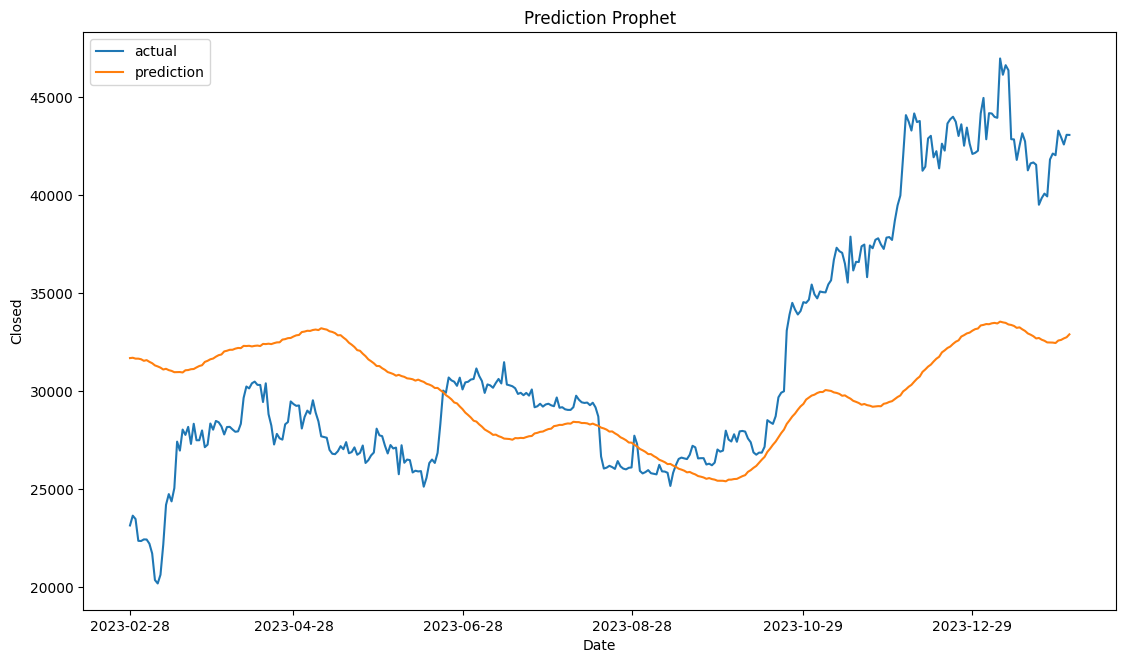

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(test['ds'], test['y'].values, label="actual")
ax.plot(test['ds'], pred, label="prediction")
ax.set_title("Prediction Prophet")
ax.set_ylabel("Closed")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [13]:
store_model(auto_model_log, "prophet_log")